In [1]:
import os, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- OS별 한글 폰트 예외 처리 (경고/깨짐 방지) ---
import platform
from matplotlib import font_manager, rcParams

def set_korean_font():
    system = platform.system()
    candidates = []
    if system == "Windows":
        candidates = ["Malgun Gothic", "맑은 고딕"]
    elif system == "Darwin":  # macOS
        candidates = ["AppleGothic", "Apple SD Gothic Neo"]
    else:  # Linux
        candidates = ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]

    available = set(f.name for f in font_manager.fontManager.ttflist)
    for c in candidates:
        if c in available:
            rcParams["font.family"] = c
            break

    rcParams["axes.unicode_minus"] = False

set_korean_font()

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

In [11]:
# --- 강제 리셋: label_col을 CatMis로 고정 ---
assert "Category" in train.columns and "Misconception" in train.columns

train["CatMis"] = train["Category"].astype(str) + ":" + train["Misconception"].astype(str)

label_col = "CatMis"  # <-- 여기서 강제로 고정
print("✅ Using label_col:", label_col)
print("✅ Exists in columns:", label_col in train.columns)
print(train[label_col].head())

✅ Using label_col: CatMis
✅ Exists in columns: True
0    True_Correct:nan
1    True_Correct:nan
2    True_Neither:nan
3    True_Neither:nan
4    True_Correct:nan
Name: CatMis, dtype: object


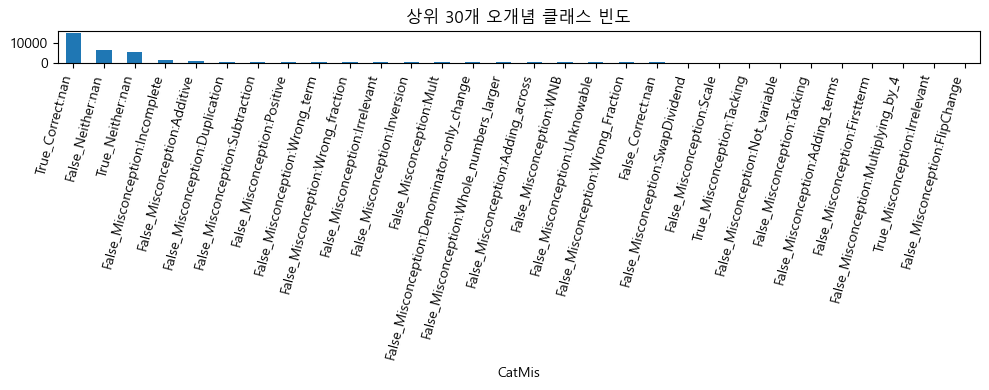

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Figure size 600x400 with 0 Axes>

In [12]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.data_load import load_train
from src.preprocessing import add_text_column

# train = load_train()
# train = add_text_column(train)  # text 컬럼 생성 (Q/A/E 합치는 로직)


import numpy as np
import matplotlib.pyplot as plt

counts = train[label_col].value_counts()

# 상위 30개 클래스
plt.figure(figsize=(10,4))
counts.head(30).plot(kind="bar")
plt.xticks(rotation=75, ha="right")
plt.title("상위 30개 오개념 클래스 빈도")
plt.tight_layout()
plt.show()

# long-tail 분포 확인 (log scale)
plt.figure(figsize=(6,4))
np.log1p(counts.values).plot()
plt.title("오개념 클래스 분포 (log scale)")
plt.xlabel("Class rank")
plt.ylabel("log(1 + count)")
plt.tight_layout()
plt.show()

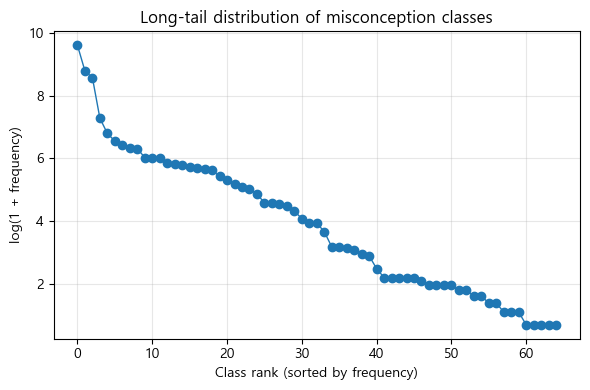

In [13]:
plt.figure(figsize=(6,4))
plt.plot(np.log1p(counts.values), marker="o", linewidth=1)
plt.xlabel("Class rank (sorted by frequency)")
plt.ylabel("log(1 + frequency)")
plt.title("Long-tail distribution of misconception classes")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

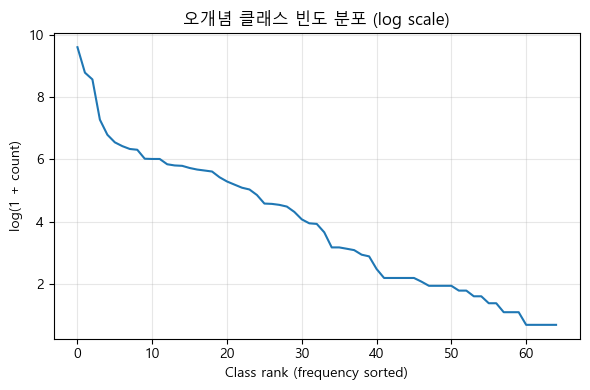

In [14]:
# CatMis 생성 (이미 있으면 재생성해도 문제 없음)
train["CatMis"] = train["Category"].astype(str) + ":" + train["Misconception"].astype(str)
counts = train["CatMis"].value_counts()

plt.figure(figsize=(6,4))
plt.plot(np.log1p(counts.values))
plt.title("오개념 클래스 빈도 분포 (log scale)")
plt.xlabel("Class rank (frequency sorted)")
plt.ylabel("log(1 + count)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "fig1_longtail_log.png", dpi=200)
plt.show()

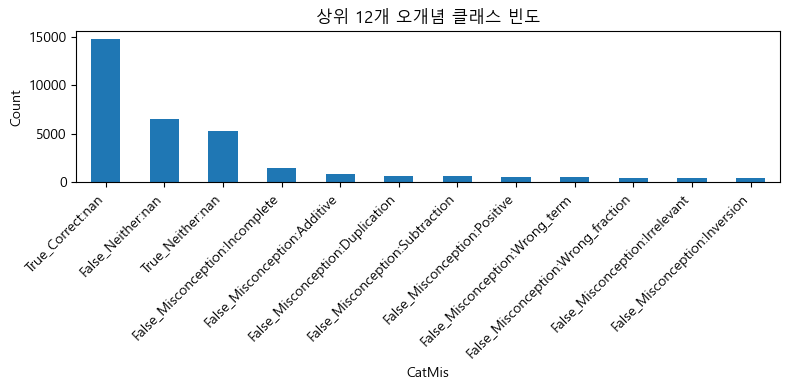

In [15]:
top_k = 12

plt.figure(figsize=(8,4))
counts.head(top_k).plot(kind="bar")
plt.title(f"상위 {top_k}개 오개념 클래스 빈도")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig2_topk_classes.png", dpi=200)
plt.show()

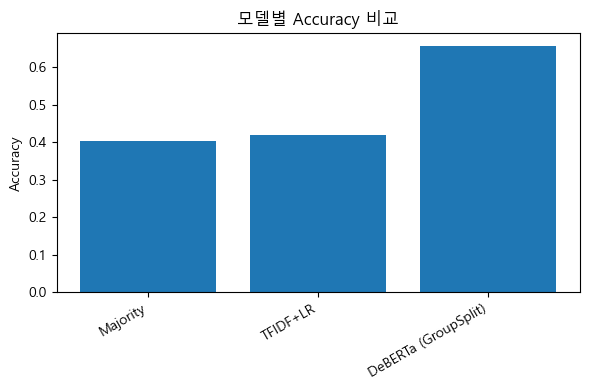

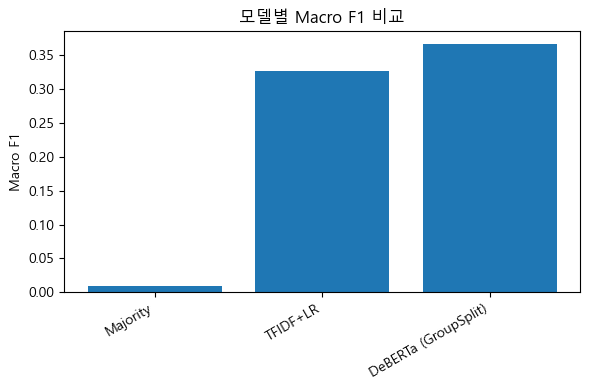

In [17]:

results = pd.DataFrame([
    {"Model":"Majority", "Accuracy":0.403, "MacroF1":0.010},
    {"Model":"TFIDF+LR", "Accuracy":0.421, "MacroF1":0.327},
    {"Model":"DeBERTa (GroupSplit)", "Accuracy":0.658, "MacroF1":0.367},

])

# Accuracy 비교
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["Accuracy"])
plt.xticks(rotation=30, ha="right")
plt.title("모델별 Accuracy 비교")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig3_accuracy_compare.png", dpi=200)
plt.show()

# Macro F1 비교
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["MacroF1"])
plt.xticks(rotation=30, ha="right")
plt.title("모델별 Macro F1 비교")
plt.ylabel("Macro F1")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig3_macroF1_compare.png", dpi=200)
plt.show()

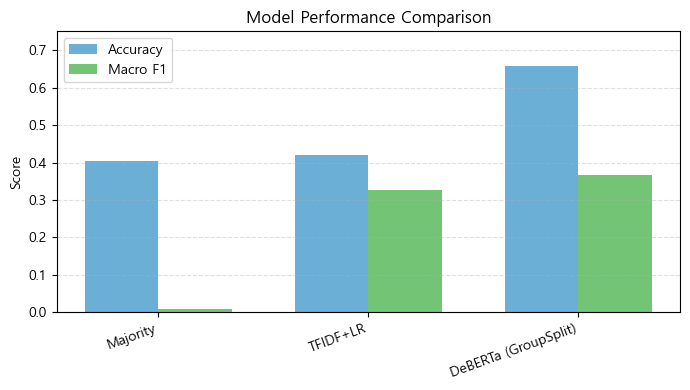

<Figure size 640x480 with 0 Axes>

In [19]:
x = np.arange(len(results))
width = 0.35

plt.figure(figsize=(7,4))

plt.bar(x - width/2, results["Accuracy"], width, label="Accuracy", color="#6BAED6")
plt.bar(x + width/2, results["MacroF1"], width, label="Macro F1", color="#74C476")

plt.xticks(x, results["Model"], rotation=20, ha="right")
plt.ylabel("Score")
plt.ylim(0, 0.75)
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig(FIG_DIR / "fig3_combined.png", dpi=300)
plt.show()


from pathlib import Path

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)
plt.savefig(FIG_DIR / "fig3_macroF1_compare.png", dpi=300)
plt.show()



In [20]:
import json

def plot_trainer_curve(output_dir: str, metric="eval_macro_f1"):
    output_dir = Path(output_dir)
    state_path = output_dir / "trainer_state.json"
    if not state_path.exists():
        print("Not found:", state_path)
        return

    state = json.loads(state_path.read_text(encoding="utf-8"))
    logs = pd.DataFrame(state.get("log_history", []))

    if metric not in logs.columns:
        print(f"[{output_dir.name}] '{metric}' not found. columns:", logs.columns.tolist())
        return
    
    x = logs["epoch"] if "epoch" in logs.columns else np.arange(len(logs))
    y = logs[metric]

    plt.figure(figsize=(6,4))
    plt.plot(x, y)
    plt.title(f"{output_dir.name} - {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    out = FIG_DIR / f"fig4_{output_dir.name}_{metric}.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("saved:", out)

plot_trainer_curve("results_QAE", "eval_macro_f1")
plot_trainer_curve("results_QAE", "eval_loss")

Not found: results_QAE\trainer_state.json
Not found: results_QAE\trainer_state.json


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# val set에서 y_true, y_pred가 있어야 함
# y_val, pred_lr 또는 transformer_pred 같은 배열을 넣어줘
y_true = y_val
y_pred = pred  # 예: TFIDF+LR 예측

topN = 12
top_labels = counts.head(topN).index.tolist()

def map_other(y, top_labels):
    return np.array([yy if yy in top_labels else "OTHER" for yy in y])

yt = map_other(y_true, top_labels)
yp = map_other(y_pred, top_labels)
labels = top_labels + ["OTHER"]

cm = confusion_matrix(yt, yp, labels=labels)

plt.figure(figsize=(10,8))
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix (Top classes + OTHER)")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig5_confusion_top_other.png", dpi=200)
plt.show()

NameError: name 'y_val' is not defined

In [22]:
import numpy as np

# label(문자열) 만들기: Category:Misconception
train["CatMis"] = train["Category"].astype(str) + ":" + train["Misconception"].astype(str)

counts = train["CatMis"].value_counts()
print("num_classes:", counts.shape[0], "min/max:", counts.min(), counts.max())

num_classes: 65 min/max: 1 14802


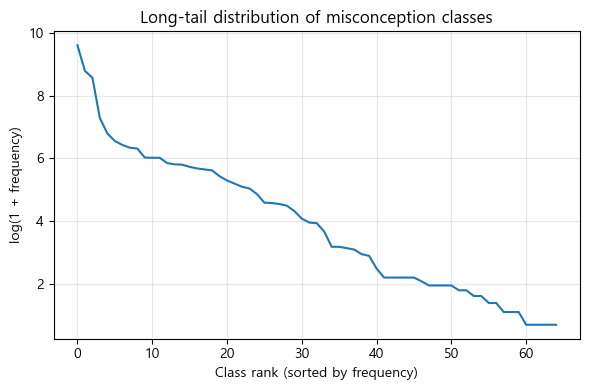

In [23]:
plt.figure(figsize=(6,4))
plt.plot(np.log1p(counts.values))
plt.xlabel("Class rank (sorted by frequency)")
plt.ylabel("log(1 + frequency)")
plt.title("Long-tail distribution of misconception classes")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "fig1_longtail_log.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

counts = train[label_col].value_counts()

# 상위 30개 클래스
plt.figure(figsize=(10,4))
counts.head(30).plot(kind="bar")
plt.xticks(rotation=75, ha="right")
plt.title("상위 30개 오개념 클래스 빈도")
plt.tight_layout()
plt.show()

# long-tail 분포 확인 (log scale)
plt.figure(figsize=(6,4))
np.log1p(counts.values).plot()
plt.title("오개념 클래스 분포 (log scale)")
plt.xlabel("Class rank")
plt.ylabel("log(1 + count)")
plt.tight_layout()
plt.show()

KeyError: 'label'

In [10]:
print(train.columns.tolist())
print("label_col =", label_col)
print("columns has label?", "label" in train.columns)

['row_id', 'QuestionId', 'QuestionText', 'MC_Answer', 'StudentExplanation', 'Category', 'Misconception', 'text']
label_col = label
columns has label? False
